<a href="https://colab.research.google.com/github/EVA4-RS-Group/Phase2/blob/master/S2_mobilenet_v2_custom_dataset/EVA4_S2_mobilnet_v2_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Loading Libraries

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
from google.colab import drive
import sys
%load_ext autoreload
%autoreload 2
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
cd  gdrive/'My Drive'/'Large QuadCopters'

/content/gdrive/.shortcut-targets-by-id/1j9OumS-K4ZoAm7oMRVG7DWUXo7EwwgLw/Large QuadCopters


In [ ]:
url = '/content/gdrive/.shortcut-targets-by-id/1j9OumS-K4ZoAm7oMRVG7DWUXo7EwwgLw/Large QuadCopters/'

# 2. Load Data & Set Data Loaders
We will use torchvision and torch.utils.data packages for loading the data.

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

In [54]:
rm -R tiny-imagenet-200/

In [55]:
import os
import zipfile
from io import StringIO,BytesIO
import requests
from tqdm import notebook

def download_images(url):
    r = requests.get(url, stream=True)
    print ('Downloading  Data' )
    zip_ref = zipfile.ZipFile(BytesIO(r.content))
    for file in notebook.tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
      zip_ref.extract(member = file)
    zip_ref.close()
        

IMAGES_URL = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
download_folder ="/content/data/"
download_images (IMAGES_URL)
       
fileName = "tiny-imagenet-200"
if (os.path.isfile(download_folder+ fileName+".zip")):
       print (download_folder+ fileName+".zip" + " exists")
else:
       print (download_folder+ fileName+".zip" " does not exists")
if (os.path.exists(download_folder+ fileName)):
       print (download_folder + fileName + " exists")
else:
       print (download_folder + fileName +  " does not exists")
       with zipfile.ZipFile(download_folder+ fileName +".zip", 'r') as zip: 
          try:
              #zip.printdir() 
                print('Extracting file ' + fileName + ' now... to ',download_folder) 
                zip.extractall() 
                print('File Extraction Done!') 
          except:
              print ("Exception to Unzip file",fileName)



tiny-imagenet-200 does not exists
/content/data/tiny-imagenet-200 exists


In [ ]:
import torch.utils.data
from torch.utils.data import Dataset, random_split
from PIL import Image
import numpy as np
import torch
import os
import torchvision.transforms as transforms
from tqdm import notebook

class ImageDataSet(Dataset):
    def __init__(self,url,classes):
        self.data = []
        self.url = url
        self.classes = classes
        print(url)
        #for image_file in notebook.tqdm(os.listdir(url):
        for image_file in os.listdir(url):
           if(image_file.endswith('.jpg')):
              img = Image.open(url + image_file)
              print(url+ image_file)
              npimg = np.asarray(img)            
              #if(len(npimg.shape) ==2):
              #   npimg = np.repeat(npimg[:, :, np.newaxis], 3, axis=2)
              self.data.append(npimg)  
              del npimg
           del image_file
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        return data

dataset = ImageDataSet(url,classes = [])
print(len(dataset))
train_split = 70
train_len = len(dataset)*train_split//100
test_len = len(dataset) - train_len 
train_set, val_set = random_split(dataset, [train_len, test_len])

/content/gdrive/.shortcut-targets-by-id/1j9OumS-K4ZoAm7oMRVG7DWUXo7EwwgLw/Large QuadCopters/
/content/gdrive/.shortcut-targets-by-id/1j9OumS-K4ZoAm7oMRVG7DWUXo7EwwgLw/Large QuadCopters/All-new-K70-WiFi-FPV-remote-Control-Large-Size-big-Drone-With-2mp-Camera-HD-One.jpg_q50.jpg
/content/gdrive/.shortcut-targets-by-id/1j9OumS-K4ZoAm7oMRVG7DWUXo7EwwgLw/Large QuadCopters/images35.jpg
/content/gdrive/.shortcut-targets-by-id/1j9OumS-K4ZoAm7oMRVG7DWUXo7EwwgLw/Large QuadCopters/images59.jpg
/content/gdrive/.shortcut-targets-by-id/1j9OumS-K4ZoAm7oMRVG7DWUXo7EwwgLw/Large QuadCopters/FOHHL0KJ1GOUZC2.LARGE.jpg
/content/gdrive/.shortcut-targets-by-id/1j9OumS-K4ZoAm7oMRVG7DWUXo7EwwgLw/Large QuadCopters/images61.jpg
/content/gdrive/.shortcut-targets-by-id/1j9OumS-K4ZoAm7oMRVG7DWUXo7EwwgLw/Large QuadCopters/images90.jpg
/content/gdrive/.shortcut-targets-by-id/1j9OumS-K4ZoAm7oMRVG7DWUXo7EwwgLw/Large QuadCopters/drone-jumpbo-q6-wifi-fpv-large-size-quadcopter.jpg
/content/gdrive/.shortcut-targets-by-id/1j

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


/content/gdrive/.shortcut-targets-by-id/1j9OumS-K4ZoAm7oMRVG7DWUXo7EwwgLw/Large QuadCopters/PowerEgg-drone-flying-home.jpg
/content/gdrive/.shortcut-targets-by-id/1j9OumS-K4ZoAm7oMRVG7DWUXo7EwwgLw/Large QuadCopters/flipdish-manna-drone.jpg
/content/gdrive/.shortcut-targets-by-id/1j9OumS-K4ZoAm7oMRVG7DWUXo7EwwgLw/Large QuadCopters/Drone-deliveries-UPS-CVS-prescriptions-FAA-news.jpg
/content/gdrive/.shortcut-targets-by-id/1j9OumS-K4ZoAm7oMRVG7DWUXo7EwwgLw/Large QuadCopters/is_drone_delivery_taking_flight.jpg
/content/gdrive/.shortcut-targets-by-id/1j9OumS-K4ZoAm7oMRVG7DWUXo7EwwgLw/Large QuadCopters/impact-of-drone-delivery-main.jpg
/content/gdrive/.shortcut-targets-by-id/1j9OumS-K4ZoAm7oMRVG7DWUXo7EwwgLw/Large QuadCopters/58b6074840b99.image.jpg
/content/gdrive/.shortcut-targets-by-id/1j9OumS-K4ZoAm7oMRVG7DWUXo7EwwgLw/Large QuadCopters/5d624a6479da3e1aecf2c838-faab.jpg
/content/gdrive/.shortcut-targets-by-id/1j9OumS-K4ZoAm7oMRVG7DWUXo7EwwgLw/Large QuadCopters/europe-times-european-daily-

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transforms =  transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_transforms = transforms.Compose([    
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

import torchvision.transforms as transforms
class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [ ]:
SEED = 1
cuda = torch.cuda.is_available()
torch.manual_seed(SEED)
if cuda:
			torch.cuda.manual_seed(SEED)
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory) if cuda else dict(shuffle=True, batch_size=64)

train_dataset = DatasetFromSubset(train_set, transform=train_transforms)
test_dataset = DatasetFromSubset(val_set, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)
testloader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)
print(len(trainloader.dataset)) 
print(len(testloader.dataset))

2592
1111


# 3. Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# 4. Training the model
Now, let’s write a general function to train a model. Here, we will illustrate:

Scheduling the learning rate
Saving the best model
In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.

In [ ]:
 def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# 5. Visualizing the model predictions
Generic function to display predictions for a few images

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#6. Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

In [ ]:
model_ft = models.mobilenet_v2(pretrained=True)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[1] = nn.Linear(1280, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 7. Train and evaluate
It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4575 Acc: 0.7459
val Loss: 0.2822 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.7143 Acc: 0.7131
val Loss: 0.3574 Acc: 0.8627

Epoch 2/24
----------
train Loss: 0.5801 Acc: 0.7746
val Loss: 0.3479 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.5014 Acc: 0.8033
val Loss: 0.4846 Acc: 0.8105

Epoch 4/24
----------
train Loss: 0.7533 Acc: 0.7049
val Loss: 0.3988 Acc: 0.8366

Epoch 5/24
----------
train Loss: 0.4668 Acc: 0.8156
val Loss: 0.3836 Acc: 0.8758

Epoch 6/24
----------
train Loss: 0.4413 Acc: 0.8238
val Loss: 0.3428 Acc: 0.8562

Epoch 7/24
----------
train Loss: 0.4260 Acc: 0.8156
val Loss: 0.2872 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.4670 Acc: 0.8074
val Loss: 0.3387 Acc: 0.8562

Epoch 9/24
----------
train Loss: 0.4748 Acc: 0.7951
val Loss: 0.2964 Acc: 0.8627

Epoch 10/24
----------
train Loss: 0.3357 Acc: 0.8484
val Loss: 0.2533 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.2712 Acc: 0.8811
val Loss: 0.2618 Acc: 0.9020

Ep

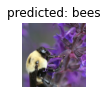

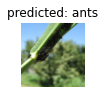

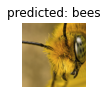

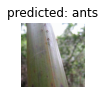

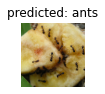

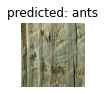

In [ ]:
visualize_model(model_ft)

# 8. ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here.

In [ ]:
model_conv = models.mobilenet_v2(pretrained=True)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_conv.classifier[1] = nn.Linear(1280, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier[1].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3618 Acc: 0.8525
val Loss: 0.1331 Acc: 0.9542

Epoch 1/24
----------
train Loss: 0.2757 Acc: 0.8852
val Loss: 0.1302 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.2668 Acc: 0.8811
val Loss: 0.1440 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.2821 Acc: 0.8648
val Loss: 0.1281 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.2954 Acc: 0.8689
val Loss: 0.1675 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.4219 Acc: 0.8279
val Loss: 0.1239 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.3114 Acc: 0.8811
val Loss: 0.1179 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.3575 Acc: 0.8361
val Loss: 0.1694 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.2794 Acc: 0.8566
val Loss: 0.1321 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3707 Acc: 0.8566
val Loss: 0.1473 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3347 Acc: 0.8443
val Loss: 0.1370 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2969 Acc: 0.8689
val Loss: 0.1216 Acc: 0.9477

Ep

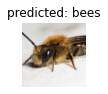

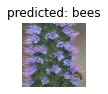

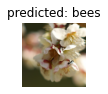

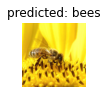

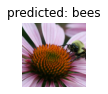

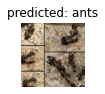

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()